# A Spring undergoing a noisy bath

Created by Wenhan Hua
June 10th

In [22]:
import numpy as np
from scipy.fft import fft, fftfreq, ifft
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks

In [23]:
# spring constant
m = 0.01
k = 1

# initial situation
x0 = 1
v0 = 0.
Vec0 = x0, v0

# simulation
TotalTime = 1e4
dt = 1e-2



In [24]:

# nosie 
U_rms = 1e0
QualityFactor = 1e3
fres = 1
samples = TotalTime * 1.05 / dt
# 1.5 is used to make  sure 
samplerate = 1 / dt
t = np.linspace(0, samples / samplerate, int(samples))
bandwidth = U_rms

# generate a initial noise signal(time domain)
signal = np.random.normal(0, bandwidth, size = len(t))
X = np.fft.fft(signal)
tf = np.fft.fftfreq(len(signal), dt)
N = len(X)
freqs = np.fft.fftfreq(N) * samplerate
freqs[0] = 1e-10
f_U_noise = X / ( 1 + 1j * QualityFactor * (freqs / fres - fres / freqs))
#f_U_noise = X
U_noise = np.fft.ifft(f_U_noise)
JNNoise_Ex = U_noise 

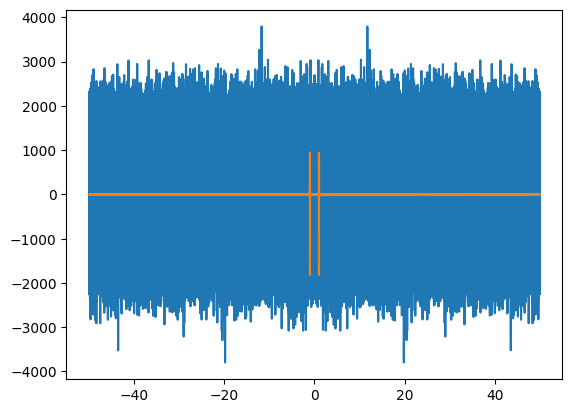

In [25]:
plt.plot(tf, X, label = 'Without Filter')
plt.plot(tf, f_U_noise, label = 'With Filter')
plt.show()

In [26]:
def DevMotion_para(t, Vec, WithNoise):
    x,  v = Vec
    a = - k * x / m
    if WithNoise:
        posi = round(t/dt)
        a = a + JNNoise_Ex[posi]
        return v, a
    else: 
        return v, a

N = int(np.round(TotalTime / dt))

        
t_eval = np.linspace(0, TotalTime, N + 1)

solution = solve_ivp(fun=lambda t, Vec: DevMotion_para(t,
                                                        Vec,
                                                        WithNoise = True), 
                            t_span = (0, TotalTime), 
                            y0 = Vec0, 
                            t_eval = t_eval, 
                            first_step = dt,
                            max_step = dt,
                            atol = 1e-1,
                            rtol = 1e-1,
                            method = 'RK45')

t_eval = solution.t
Vec_eval = solution.y
x_eval = Vec_eval[0, :]
vx_eval = Vec_eval[1, :]



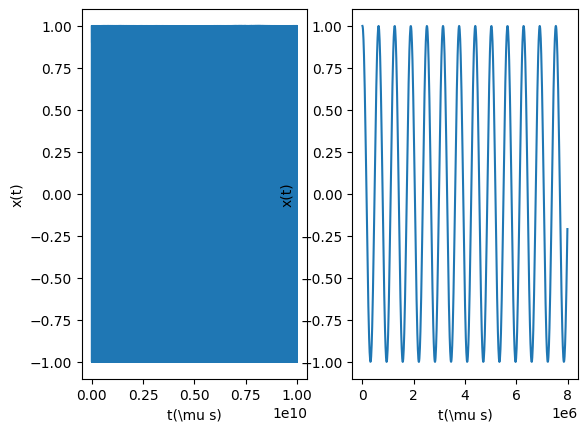

In [27]:
# Plot the x-axis motion
fig1, ax = plt.subplots(1,2)

# Plot the data on the axes
ax[0].plot(t_eval*1e6, x_eval)
# ax[0].plot(t_init*1e6, vx_init)

# Add labels to the axes
ax[0].set_xlabel('t(\mu s)')
ax[0].set_ylabel('x(t)')

# Plot the data on the axes
Zoomnum = round(8/dt)
ax[1].plot(t_eval[:Zoomnum]*1e6, x_eval[:Zoomnum])

# Add labels to the axes
ax[1].set_xlabel('t(\mu s)')
ax[1].set_ylabel('x(t)')

# Show the plot
plt.show()

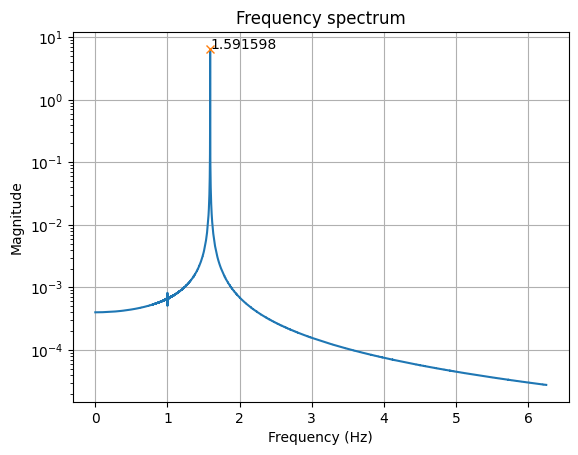

In [28]:
# Get the fourier spectrum of velocity
Amplifier_Num_init = 1

vxf_init = fft(vx_eval)
tf = fftfreq(len(vx_eval), dt / Amplifier_Num_init)

Front = 0
Cutoff = 8
vf = vxf_init[Front:Front + (vxf_init.size//Cutoff//2)]
ttf = tf[:len(vx_eval)//2]
ttf = ttf[Front:Front + (ttf.size//Cutoff)]

# Get normalized magnitude of specturm
N_vf_init = 2.0/(Amplifier_Num_init * (N+1)) * np.abs(vf[0:len(vx_eval)//2])


# use find_peaks to get all the peaks
peaks, _ = find_peaks(N_vf_init, height=0)


# we only need the three largest peaks, therefore we find a border and find peaks again
temp = N_vf_init[peaks]
temp.sort()
temp = temp[::-1]
border = ( temp[0] + temp[0])/2
#border = 0
peaks, heights = find_peaks(N_vf_init, height= border)

#print("The location of the three largest peaks is {}, {}, {} Hz".format(tf[peaks[0]], tf[peaks[1]], tf[peaks[2]]))

# Plot the result
plt.plot(ttf, N_vf_init)
plt.plot(ttf[peaks], N_vf_init[peaks], "x")

for i in range(0,1):                                      
    #plt.text(ttf[peaks[i]], N_vf_init[peaks[i]], "%f" % N_vf[peaks[i]])
    plt.text(ttf[peaks[i]], N_vf_init[peaks[i]], "%f" % ttf[peaks[i]])

# Regenerate the resonator's frequency by the third peak position
fres = ttf[peaks[0]]

# Calculate the average of the velocity in the first micromotion peroid
Tradical = 1 / ttf[peaks[0]]
#Nsec = round(Tradical / dt * Amplifier_Num_init)

#vx_Nsec = list(vx_init[: Nsec])
#vy_Nsec = list(vy_init[: Nsec])
#vz_Nsec = list(vz_init[: Nsec])

#vx_init_Ampl = sum(abs(ele) for ele in vx_Nsec) / Nsec
#vy_init_Ampl = sum(abs(ele) for ele in vy_Nsec) / Nsec
#vz_init_Ampl = sum(abs(ele) for ele in vz_Nsec) / Nsec

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.yscale('log')
plt.title('Frequency spectrum')
plt.grid()
plt.show()

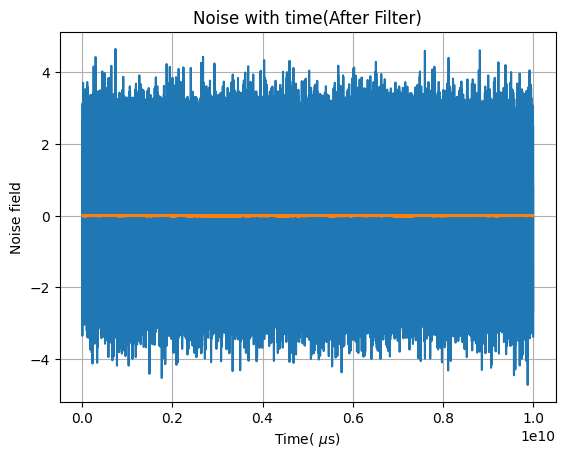

In [29]:

plt.plot(np.array(t_eval) * 1e6, signal[:len(t_eval)])
plt.plot(np.array(t_eval) * 1e6, JNNoise_Ex[:len(t_eval)])
plt.xlabel('Time( $\mu$s)')
plt.ylabel('Noise field')
plt.title('Noise with time(After Filter)')
plt.grid()
plt.show()